In [1]:
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
import sys
sys.path.append(os.path.abspath(".."))
from data import WiderFaceDetection, detection_collate, preproc, cfg_mnet, cfg_re50
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
import datetime
import math
from models.retinaface import RetinaFace
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


In [3]:
# Declare config (use resnet50 backbone)
cfg = cfg_re50
rgb_mean = (104, 117, 123) # bgr order
num_classes = 2
img_dim = cfg['image_size']
num_gpu = cfg['ngpu']
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
gpu_train = cfg['gpu_train']

initial_lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [4]:
# Instantiate model with the configurations above
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        pretrained_dict = torch.load(pretrained_path, map_location=device)
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

model_retinaface = RetinaFace(cfg=cfg, phase="test").to(device)
model_retinafafce = load_model(model_retinaface, "../Resnet50_Final.pth", False)
model_retinaface.eval()

/Users/calvin/Documents/smu/Y3S2/CS427/CS427/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/calvin/Documents/smu/Y3S2/CS427/CS427/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ../Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [6]:
# Extract 1000 non-member images and 1000 member images
category = os.listdir("../data/widerface/val/images/")
non_member_images = []
for i in range(50):
    folder = os.listdir(f"../data/widerface/val/images/{category[i]}/")
    for j in range(19):
        image_path = f"../data/widerface/val/images/{category[i]}/{folder[j]}"
        non_member_images.append(image_path)

category = os.listdir("../data/widerface/train/images/")
member_images = []
for i in range(50):
    folder = os.listdir(f"../data/widerface/train/images/{category[i]}/")
    for j in range(19):
        image_path = f"../data/widerface/train/images/{category[i]}/{folder[j]}"
        member_images.append(image_path)

all_images = non_member_images + member_images
labels = [0] * len(non_member_images) + [1] * len(member_images)

In [25]:
# Feature extraction from RetinaFace
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm

def test_forward_pass(image_path, model, confidence_threshold):
    resize = 1
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)

    img = np.float32(img_raw)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    loc, conf, landms = model(img)  # forward pass

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data

    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()

    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])

    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMSk
    top_k = 5000
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    nms_threshold = 0.4
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    keep_top_k = 750
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    return dets

def extract_retinaface_features(image_path, model, confidence_threshold):

    dets = test_forward_pass(image_path, model, confidence_threshold)

    if dets is None or len(dets) == 0:
        return [0, 0, 0, 0]
    
    confidences = dets[:, 4]
    num_faces = len(confidences)

    max_conf = float(np.max(confidences))
    avg_conf = float(np.mean(confidences))

    sum_conf = np.sum(confidences)
    normalized = confidences / (sum_conf + 1e-9)
    entropy = -np.sum(normalized * np.log(normalized + 1e-9))

    return [num_faces, max_conf, avg_conf, entropy]

In [ ]:
# Build attack dataset
x = []
y = []

count = 0
for img_path, label in zip(all_images, labels):
    features = extract_retinaface_features(img_path, model_retinaface, 0.5)
    x.append(features)
    y.append(label)
    count += 1

    if count % 10 == 0:
        print(count)

x = np.array(x)
y = np.array(y)

print("Feature Shape:", x.shape)
print("Labels Shape:", y.shape)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
Feature Shape: (1900, 4)
Labels Shape: (1900,)


In [5]:
# Training the attack model
from sklearn.model_selection import train_test_split

if os.path.exists("attack_dataset.npz"):
    data = np.load("attack_dataset.npz")
    x, y = data['x'], data['y']
else:
    # your feature extraction loop
    np.savez("attack_dataset.npz", x=x, y=y)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
attack_model = RandomForestClassifier(n_estimators=50, random_state=42)
attack_model.fit(x_train, y_train)

y_pred = attack_model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, attack_model.predict_proba(x_test)[:,1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Attack Model Accuracy on Test: {acc:.3f}")
print(f"Attack Model AUC on Test:      {auc:.3f}")
print(f"Attack Model Precision on Test: {precision:.3f}")
print(f"Attack Model Recall on Test:    {recall:.3f}")
print(f"Attack Model F1 Score on Test:  {f1:.3f}")

Attack Model Accuracy on Test: 0.484
Attack Model AUC on Test:      0.501
Attack Model Precision on Test: 0.485
Attack Model Recall on Test:    0.435
Attack Model F1 Score on Test:  0.459


In [7]:
#### CIFAR10 ####
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import random
import ast
import numpy as np

class ClassifierNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        self.fc6 = nn.Linear(4, 2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x


def save_model(model, name):
    torch.save(model.state_dict(), name)


def load_model(model_class, name, *args):
    model = model_class(*args)
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))

    return model


def train(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print('loss: {:.4f} [{}/{}]'.format(loss, current, size))


def print_model(model):
    for name, param in model.named_parameters():
        print(name)
        print(param.data)


def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    loss, correct = 0.0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)

            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()

    loss /= num_batches
    correct /= size
    print('Test Error: \n Accuracy: {:.2f}%, Avg loss: {:.4f}\n'.format(100 * correct, loss))

    return correct / size

#the following function evaluates the precision and recall of the member predictor.
def evaluate_with_sklearn(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Now use sklearn to compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")

def get_loader(data_file, kwargs):
    data_file = open(data_file, 'r')
    input_data, label_data = [], []

    for line in data_file.readlines():
        data = ast.literal_eval(line)
        input_data.append(data[:-1])
        label_data.append(data[-1])

    input_data = np.array(input_data)
    label_data = np.array(label_data)

    input_data_tensor = torch.Tensor(input_data)
    label_data_tensor = torch.Tensor(label_data).type(torch.LongTensor)

    dataset = TensorDataset(input_data_tensor, label_data_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=True, **kwargs)

    return data_loader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed
set_seed(42)


In [8]:
# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Build a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Make your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [9]:
model = ClassifierNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# 3) Training loop
num_of_epochs = 300
best_acc = 0.0

for epoch in range(num_of_epochs):
    print(f'\n--- Epoch {epoch} ---\n')
    train(model, train_loader, loss_fn, optimizer, device)
    acc = test(model, test_loader, loss_fn, device)
    
    # Save best model
    if acc > best_acc:
        save_model(model, "mia_classifier.pt")
        best_acc = acc

# 4) Reload the best model and do a final test
model = load_model(ClassifierNet, "mia_classifier.pt")
model = model.to(device)
test(model, test_loader, loss_fn, device)

# 5) Evaluate precision and recall
evaluate_with_sklearn(model, test_loader, device)


--- Epoch 0 ---

loss: 0.7293 [0/1520]
Test Error: 
 Accuracy: 47.89%, Avg loss: 0.6974


--- Epoch 1 ---

loss: 0.7363 [0/1520]
Test Error: 
 Accuracy: 48.68%, Avg loss: 0.6964


--- Epoch 2 ---

loss: 0.6904 [0/1520]
Test Error: 
 Accuracy: 47.37%, Avg loss: 0.6958


--- Epoch 3 ---

loss: 0.7065 [0/1520]
Test Error: 
 Accuracy: 47.63%, Avg loss: 0.6954


--- Epoch 4 ---

loss: 0.6960 [0/1520]
Test Error: 
 Accuracy: 46.84%, Avg loss: 0.6951


--- Epoch 5 ---

loss: 0.6918 [0/1520]
Test Error: 
 Accuracy: 47.37%, Avg loss: 0.6948


--- Epoch 6 ---

loss: 0.6971 [0/1520]
Test Error: 
 Accuracy: 47.89%, Avg loss: 0.6946


--- Epoch 7 ---

loss: 0.6907 [0/1520]
Test Error: 
 Accuracy: 47.89%, Avg loss: 0.6945


--- Epoch 8 ---

loss: 0.6907 [0/1520]
Test Error: 
 Accuracy: 48.16%, Avg loss: 0.6943


--- Epoch 9 ---

loss: 0.6958 [0/1520]
Test Error: 
 Accuracy: 48.68%, Avg loss: 0.6942


--- Epoch 10 ---

loss: 0.6919 [0/1520]
Test Error: 
 Accuracy: 49.47%, Avg loss: 0.6941


--- Epoc

Metric-based MIA AUC (Random Forest Classifier): 0.702


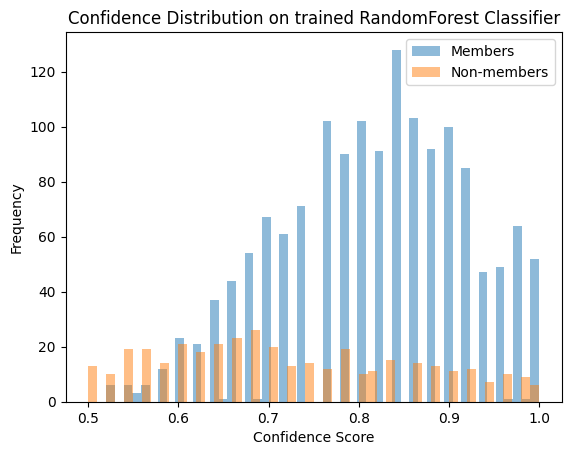

In [10]:
# Metric based MIA (Random Forest Classifier)

def get_confidence_scores(model, x):
    probs = model.predict_proba(x)
    return probs.max(axis=1)

# Scores
train_confidences = get_confidence_scores(attack_model, x_train)
test_confidences = get_confidence_scores(attack_model, x_test)

labels = [1] * len(train_confidences) + [0] * len(test_confidences)
scores = list(train_confidences) + list(test_confidences)

auc = roc_auc_score(labels, scores)
print(f"Metric-based MIA AUC (Random Forest Classifier): {auc:.3f}")

plt.hist(train_confidences, bins=50, alpha=0.5, label='Members')
plt.hist(test_confidences, bins=50, alpha=0.5, label='Non-members')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution on trained RandomForest Classifier')
plt.legend()
plt.show()

Metric-based MIA AUC (ClassifierNet): 0.498


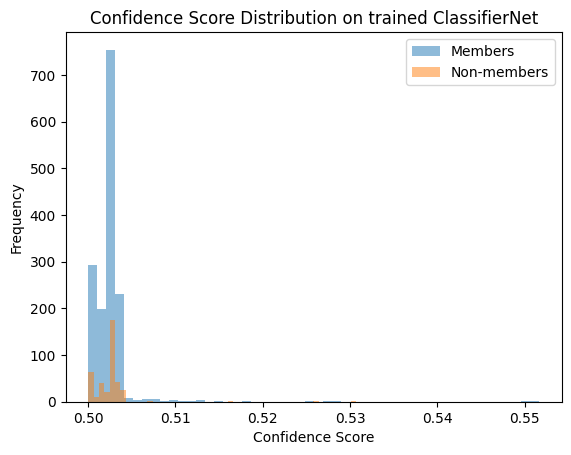

In [11]:
# Metric based MIA (ClassiferNet)
def get_confidence_scores(model, dataloader, device):
    model.eval()
    confidences = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)
            top_confidence = probs.max(dim=1).values
            confidences.extend(top_confidence.cpu().numpy())
    return confidences


# Get scores
train_confidences = get_confidence_scores(model, train_loader, device)
test_confidences = get_confidence_scores(model, test_loader, device)

# Labels: 1 for member, 0 for non-member
labels = [1] * len(train_confidences) + [0] * len(test_confidences)
scores = train_confidences + test_confidences

# Metric: AUC
auc = roc_auc_score(labels, scores)
print(f"Metric-based MIA AUC (ClassifierNet): {auc:.3f}")

# Optional: visualize distributions
plt.hist(train_confidences, bins=50, alpha=0.5, label="Members")
plt.hist(test_confidences, bins=50, alpha=0.5, label="Non-members")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Score Distribution on trained ClassifierNet")
plt.legend()
plt.show()

Metric-based MIA AUC (Feature 2): 0.530


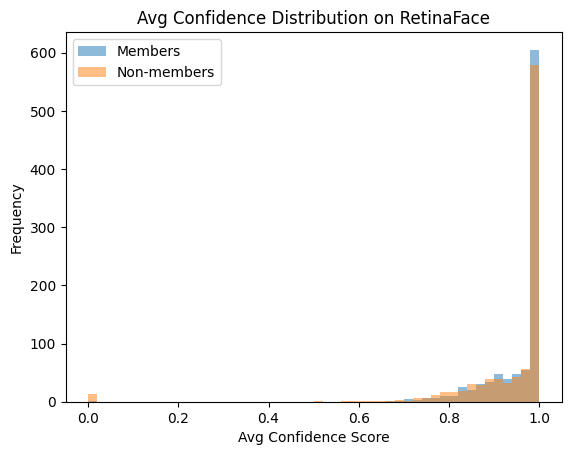

In [15]:
# Metric based MIA (RetinaFace Model)

x = data['x']
y = data['y']
feature_idx = 2
scores = x[:, feature_idx]

# Compute AUC
auc = roc_auc_score(y, scores)
print(f"Metric-based MIA AUC (Feature {feature_idx}): {auc:.3f}")

# Optional: plot distributions
member_scores = scores[y == 1]
nonmember_scores = scores[y == 0]

plt.hist(member_scores, bins=50, alpha=0.5, label="Members")
plt.hist(nonmember_scores, bins=50, alpha=0.5, label="Non-members")
plt.xlabel("Avg Confidence Score")
plt.ylabel("Frequency")
plt.title(f"Avg Confidence Distribution on RetinaFace")
plt.legend()
plt.show()

In [28]:
# Forward propagate both 950 images 
# Compare their average confidence scores etc
avg_confidence_member = 0
avg_confidence_non_member = 0

max_confidence_member = 0
max_confidence_non_member = 0

for features, label in zip(x, y):
    if label == 0:
        avg_confidence_non_member += features[2]
        max_confidence_non_member = max(max_confidence_non_member, features[1])
    else:
        avg_confidence_member += features[2]
        max_confidence_member = max(max_confidence_member, features[1])

print(f"Average confidence non member = {avg_confidence_non_member / 950}")
print(f"Average confidence member = {avg_confidence_member / 950}")
print(f"Max confidence non member = {max_confidence_non_member}")
print(f"Max confidence member = {max_confidence_member}")

# return [num_faces, max_conf, avg_conf, entropy]

Average confidence non member = 0.9390215747607382
Average confidence member = 0.9582521776149148
Max confidence non member = 0.9999990463256836
Max confidence member = 0.9999954700469971
